In [1]:
!git clone https://github.com/reiinakano/scikit-plot.git && pip install scikit-plot
  

Cloning into 'scikit-plot'...
remote: Enumerating objects: 828, done.
remote: Total 828 (delta 0), reused 0 (delta 0), pack-reused 828
Receiving objects: 100% (828/828), 3.05 MiB | 25.78 MiB/s, done.
Resolving deltas: 100% (512/512), done.


In [2]:
!pip install --upgrade gensim

    100% |████████████████████████████████| 23.6MB 1.5MB/s 
    100% |████████████████████████████████| 1.4MB 14.7MB/s 
    100% |████████████████████████████████| 133kB 30.7MB/s 
    100% |████████████████████████████████| 4.7MB 6.8MB/s 
    100% |████████████████████████████████| 61kB 25.4MB/s 
    100% |████████████████████████████████| 552kB 24.8MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [3]:

%matplotlib inline
import warnings
import pickle
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import seaborn as sn
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
import scikitplot.metrics as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# **Utility Functions**

In [0]:
#Utility Function
def standardisation(mean):
  s = StandardScaler(with_mean = mean)
  return s
  
def knn_classifier():
  neighbors = list(range(1,7))
  knn = KNeighborsClassifier()
  parameter = {'algorithm' :['kd_tree','brute'],'n_neighbors': neighbors}
  clf = GridSearchCV(estimator = knn,param_grid =parameter,scoring='mutual_info_score',n_jobs = -1,cv=2)
  return clf

def train_set_report(clf_k):
  best_parameters = clf_k.best_params_
  best_accuracy = clf_k.best_score_
  print(best_parameters)
  print(best_accuracy)
  
def test_set_report(clf,x_test,y_test):
  pred = clf.predict(standardized_data_test)
  acc = accuracy_score(y_test, pred) * 100
  print('The test set accuracy is %f%%' %(acc))
  skplt.plot_confusion_matrix(y_test ,pred)
  print(classification_report(y_test ,pred))

def knnclassifierresults(clf):
  out = pd.DataFrame.from_dict(clf.cv_results_)
  return out

def knnAlgoGraph(result,algo):
  result = result.sort_values(by = ['rank_test_score'])
  a = (result[['param_algorithm','param_n_neighbors','mean_test_score']])
  b = a[a["param_algorithm"] == algo]
  k = b.param_n_neighbors.tolist()
  score = b.mean_test_score.tolist()
  plt.plot(k, score,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
  plt.title("Graph for "+algo)
  plt.xlabel('Number of Neighbors K')
  plt.ylabel('Accuracy score')
  plt.show()



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data **Sampling**

In [0]:
con = sqlite3.connect('/content/drive/My Drive/Dataset/AFR/final.sqlite')

In [0]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [0]:
import datetime

final["Time"] = final["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


In [0]:
final = final.iloc[0:30000]

In [10]:
final.shape

(30000, 12)

In [0]:
l = final['Score']
final = final.drop("Score", axis = 1)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(final, l, test_size=0.2, random_state=0)

# **BOW**

In [137]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_train['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24000, 19583)
the number of unique words  19583


In [138]:
final_counts_test = count_vect.transform(X_test['CleanedText'].values)
print(final_counts.shape)
print(final_counts_test.shape)

(24000, 19583)
(6000, 19583)


In [0]:
s = standardisation(False)
standardized_data = s.fit_transform(final_counts)
standardized_data_test = s.transform(final_counts_test)

In [0]:
bow_knn = knn_classifier()

In [141]:
bow_knn.fit(standardized_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'algorithm': ['kd_tree', 'brute'], 'n_neighbors': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mutual_info_score', verbose=0)

In [142]:
train_set_report(bow_knn)

{'algorithm': 'kd_tree', 'n_neighbors': 2}
0.010624277697720966


The test set accuracy is 82.133333%
             precision    recall  f1-score   support

   negative       0.25      0.31      0.28       660
   positive       0.91      0.88      0.90      5340

avg / total       0.84      0.82      0.83      6000



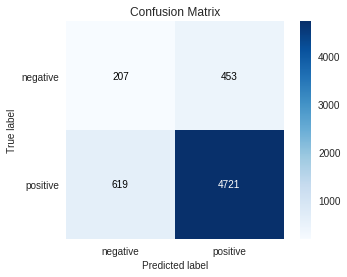

In [143]:
test_set_report(bow_knn,standardized_data_test,y_test)

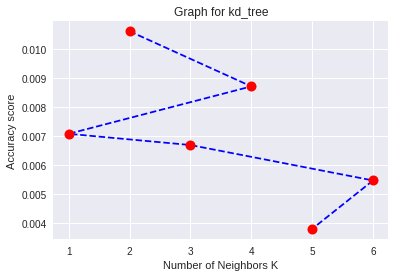

In [144]:
result = knnclassifierresults(bow_knn)
knnAlgoGraph(result,"kd_tree")

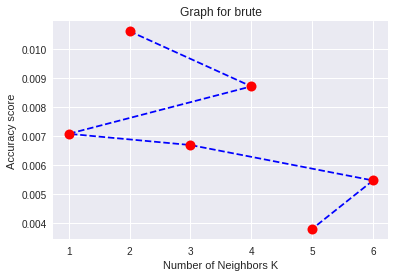

In [145]:
knnAlgoGraph(result,"brute")

# *WORD2VEC*

In [0]:
def wordList(sentence):
    listword = []
    for sent in sentence:
        listword.append(sent.split())
    return listword
        

In [0]:
list_clean_text = wordList(X_train['CleanedText'].values)

In [0]:
list_clean_text_test = wordList(X_test['CleanedText'].values)

In [16]:
print(list_clean_text[1])

['keep', 'carton', 'fridg', 'occas', 'one', 'earli', 'morn', 'doctor', 'appoint', 'exampl', 'grab', 'bar', 'eat', 'car', 'doc', 'visit', 'crunchi', 'nutti', 'nutriti', 'energi', 'bar', 'calori', 'tast', 'good', 'definit', 'someth', 'ill', 'keep', 'buy', 'found', 'amazon', 'com', 'touch', 'whether', 'could', 'get', 'place', 'carri', 'kashi', 'bar']


In [0]:
# Considering Words with minimum occurence of 5 times
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 50, workers = 2 )

In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 6695
sample words ['like', 'robust', 'overpow', 'tea', 'without', 'caffein', 'one', 'complex', 'medley', 'flavor', 'could', 'love', 'general', 'dont', 'add', 'milk', 'find', 'brew', 'goe', 'fantast', 'bit', 'dairi', 'anoth', 'benefit', 'matter', 'mani', 'time', 'doesnt', 'get', 'bore', 'keep', 'carton', 'fridg', 'occas', 'earli', 'morn', 'doctor', 'exampl', 'grab', 'bar', 'eat', 'car', 'visit', 'crunchi', 'nutti', 'nutriti', 'energi', 'calori', 'tast', 'good']


In [0]:
def w2vavg(clean,w2v_model,w2v_words):
    sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in clean:
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

        
#print(len(sent_vectors))
#print(len(sent_vectors[0]))
        

In [21]:
sent_vectors_train = w2vavg(list_clean_text,w2v_model,w2v_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

24000
50


In [82]:
sent_vectors_test = w2vavg(list_clean_text_test,w2v_model,w2v_words)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6000
50


In [0]:
sent_vectors_final_train = np.asarray(sent_vectors_train)

In [0]:
sent_vectors_final_test = np.asarray(sent_vectors_test)

In [85]:
print(sent_vectors_final_train.shape)
print(sent_vectors_final_test.shape)

(24000, 50)
(6000, 50)


In [0]:
s = standardisation(True)
standardized_data = s.fit_transform(sent_vectors_final_train)
standardized_data_test = s.transform(sent_vectors_final_test)

In [0]:
avgw2v_knn = knn_classifier()

In [89]:
import time
start_time = time.time()
avgw2v_knn.fit(standardized_data, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 396.4046423435211 seconds ---


In [90]:
train_set_report(avgw2v_knn)

{'algorithm': 'kd_tree', 'n_neighbors': 6}
0.027492396470371064


The test set accuracy is 89.483333%
             precision    recall  f1-score   support

   negative       0.54      0.27      0.36       660
   positive       0.92      0.97      0.94      5340

avg / total       0.87      0.89      0.88      6000



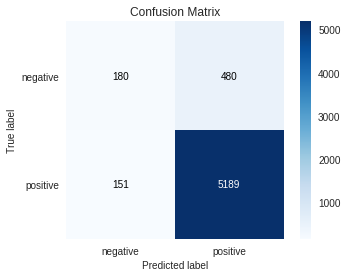

In [92]:
test_set_report(avgw2v_knn,standardized_data_test,y_test)

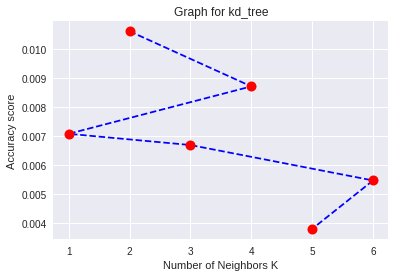

In [93]:
result = knnclassifierresults(bow_knn)
knnAlgoGraph(result,"kd_tree")

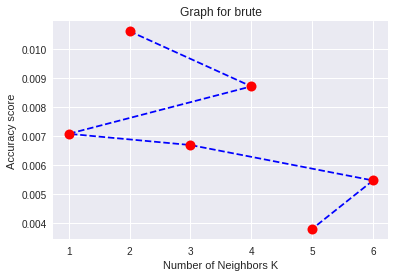

In [94]:
knnAlgoGraph(result,"brute")

# **TF-IDF**

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)

In [97]:
print("type = ", type(final_tf_idf))
print("shape = ", final_tf_idf.get_shape())
print("number of unique words ", final_tf_idf.get_shape()[1])

type =  <class 'scipy.sparse.csr.csr_matrix'>
shape =  (24000, 418270)
number of unique words  418270


In [0]:
final_tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)

In [0]:
s = standardisation(False)
standardized_data = s.fit_transform(final_tf_idf)
standardized_data_test = s.transform(final_tf_idf_test)

In [100]:
tfidf_knn = knn_classifier() 
tfidf_knn.fit(standardized_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'algorithm': ['kd_tree', 'brute'], 'n_neighbors': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mutual_info_score', verbose=0)

In [101]:
train_set_report(tfidf_knn)

{'algorithm': 'kd_tree', 'n_neighbors': 1}
0.0017313704645275981


The test set accuracy is 89.166667%
             precision    recall  f1-score   support

   negative       0.92      0.02      0.03       660
   positive       0.89      1.00      0.94      5340

avg / total       0.89      0.89      0.84      6000



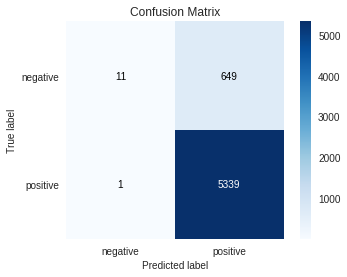

In [103]:
test_set_report(tfidf_knn,standardized_data_test,y_test)

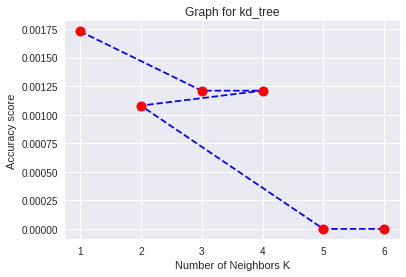

In [104]:
result = knnclassifierresults(tfidf_knn)
knnAlgoGraph(result,"kd_tree")

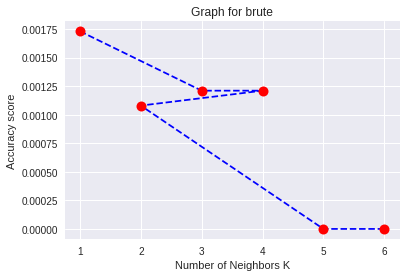

In [105]:
knnAlgoGraph(result,"brute")

# tfidfW2v

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names()

In [0]:
# TF-IDF weighted Word2Vec
def tfidfw2v(final_tf_idf,tfidf_feat,list_clean_text,w2v_model,w2v_words):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_clean_text: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if (word in w2v_words and (word in tfidf_feat)):
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
                
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [22]:
sent_vectors_train = tfidfw2v(final_tf_idf,tfidf_feat,list_clean_text,w2v_model,w2v_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

24000
50


In [23]:
sent_vectors_test = tfidfw2v(final_tf_idf,tfidf_feat,list_clean_text_test,w2v_model,w2v_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

24000
50


In [0]:
sent_vectors_final_train = np.asarray(sent_vectors_train)

In [0]:
sent_vectors_final_test = np.asarray(sent_vectors_test)

In [28]:
print(sent_vectors_final_train.shape)
print(sent_vectors_final_test.shape)

(24000, 50)
(6000, 50)


In [0]:
s = standardisation(False)
standardized_data = s.fit_transform(sent_vectors_final_train)
standardized_data_test = s.transform(sent_vectors_final_test)

In [30]:
tfidfw2v_knn = knn_classifier() 
tfidfw2v_knn.fit(standardized_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'algorithm': ['kd_tree', 'brute'], 'n_neighbors': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mutual_info_score', verbose=0)

In [31]:
train_set_report(tfidfw2v_knn)

{'algorithm': 'kd_tree', 'n_neighbors': 2}
0.02131463524280055


The test set accuracy is 75.266667%
             precision    recall  f1-score   support

   negative       0.15      0.26      0.19       660
   positive       0.90      0.81      0.85      5340

avg / total       0.82      0.75      0.78      6000



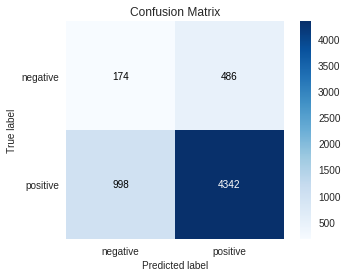

In [32]:
test_set_report(tfidfw2v_knn,standardized_data_test,y_test)

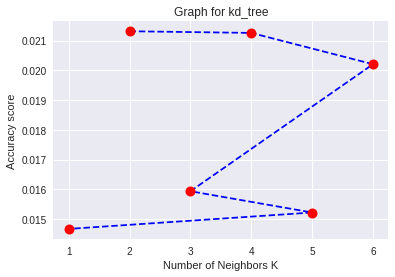

In [34]:
result = knnclassifierresults(tfidfw2v_knn)
knnAlgoGraph(result,"kd_tree")

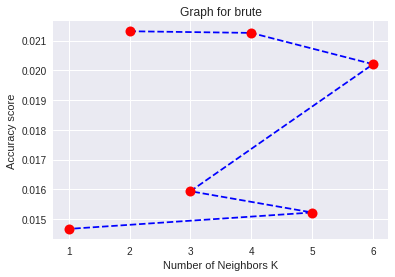

In [35]:
knnAlgoGraph(result,"brute")